In [3]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.2 MB/s eta 0:00:00


In [6]:
import deepxde as dde
dde.backend.set_default_backend("pytorch")
from deepxde.backend import torch, backend_name
import torch

import numpy as np
import matplotlib.pyplot as plt

'''
"# DeepXDE will internally create tf.keras layers with these specs."
If there is any issue with torch.sin or other torch.###,
just replace it with tf.sin or tf.###.
'''

# # For reproducibility: fix all random seeds used by DeepXDE / TensorFlow backend
# dde.config.set_random_seed(1234)

In [7]:
# Define the domain
x_min = -5
x_max = 5
t_min = 0
t_max = np.pi / 2

# Create spatial and temporal grids for plotting
x = np.linspace(x_min, x_max, 200)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)
X_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))


In [9]:
# Define the geometry and time domain for DeepXDE
geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the PDE system
def pde(x, y):
    u = y[:, 0:1]  # Real part
    v = y[:, 1:2]  # Imaginary part

    # Derivatives - Real and Imagineary part
    # Real part (1st and 2nd order derivative)
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)

    # Imaginery part (1st and 2nd order derivative)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    # Residuals
    f_u =   u_t + 0.5 * v_xx + (u**2 + v**2) * v
    f_v = - v_t + 0.5 * u_xx + (u**2 + v**2) * u
    return [f_u, f_v]

# Define the initial conditions
def ic_u_value(x):
    return 2 / np.cosh(x[:, 0:1])

def ic_v_value(x):
    return np.zeros_like(x[:, 0:1])

def on_initial(x, on_boundary):
    return on_boundary and np.isclose(x[1], t_min)

def on_boundary(x, on_boundary):
    return on_boundary


# Define the periodic boundary conditions
# PeriodicBC(geomtime, component_x, on_boundary, derivative_order=0, component=0)
# Real part - Periodic BC
bc_u = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=0, component=0)
bc_u_x = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=1, component=0)

# Imaginery part - Periodic BC
bc_v = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=0, component=1)
bc_v_x = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=1, component=1)

# Initial conidtion - Real and Imaginery parts
ic_u = dde.icbc.IC(geomtime, ic_u_value, on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, ic_v_value, on_initial, component=1)


# Combine the PDE, initial conditions, and boundary conditions into a single dataset
data = dde.data.TimePDE(
    geomtime,              # Space–time domain (e.g., [x_min, x_max] × [t_min, t_max])
    pde,                   # Function that defines the PDE residual (F = 0 form)
    [ic_u, ic_v,           # Initial conditions for the two fields u(x, t), v(x, t)
     bc_u, bc_u_x,         # Boundary conditions for u and its spatial derivative (e.g., Neumann/Robin)
     bc_v, bc_v_x],        # Boundary conditions for v and its spatial derivative
    num_domain=5000,       # Number of interior collocation points in space–time
    num_boundary=200,      # Number of boundary points (x at boundaries over time)
    num_initial=200,       # Number of initial-condition points (x at t = t0)
)


# Define a fully connected neural network to approximate [u(x, t), v(x, t)]
layer_size = [2] + [100] * 4 + [2]
# layer_size explanation:
#   - Input dimension : 2  (x, t)
#   - Hidden layers   : 4 layers, each with 100 neurons
#   - Output dimension: 2  (u, v)

activation = "tanh"              # Nonlinear activation used in all hidden layers
initializer = "Glorot uniform"   # Xavier/Glorot uniform initialization for network weights

# Build the feedforward neural network with the specified architecture
net = dde.nn.FNN(layer_size, activation, initializer)


# Create the physics-informed model by combining the data (PDE + IC/BC) and the network
model = dde.Model(data, net)


# -------- Stage 1: Train with Adam (first-order optimizer) --------
# Compile the model with Adam optimizer for fast, robust initial training
model.compile(
    "adam",         # Optimizer name
    lr=0.001        # Learning rate
)

# Train for a fixed number of iterations (epochs)
model.train(iterations=5000)


# -------- Stage 2: Refine with L-BFGS (second-order optimizer) --------
# L-BFGS often improves convergence after Adam by fine-tuning around a good minimum
# (Optional) Set custom L-BFGS options via:
# dde.optimizers.config.set_LBFGS_options(maxiter=10000)

model.compile("L-BFGS")  # Switch optimizer to L-BFGS
model.train()            # Run until L-BFGS converges (no explicit iteration limit passed)


# -------- Post-processing: Predict on a test grid and compute derived quantity --------
# X_test should be an array of shape (N_test, 2) with columns [x, t]

prediction = model.predict(X_test)   # prediction.shape = (N_test, 2) → [u_pred_flat, v_pred_flat]

# Reshape u and v into 2D arrays for visualization (e.g., x × t grid: 100 x-points, 200 t-points)
u_pred = prediction[:, 0].reshape(100, 200)   # u(x_i, t_j)
v_pred = prediction[:, 1].reshape(100, 200)   # v(x_i, t_j)

# Compute the magnitude h = sqrt(u^2 + v^2), e.g., speed if (u, v) is a velocity field
h_pred = np.sqrt(u_pred**2 + v_pred**2)



Compiling model...
'compile' took 0.040568 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [2.29e-03, 1.72e-03, 8.05e-01, 2.38e-02, 5.66e-02, 2.71e-06, 1.01e-01, 4.74e-05]    [2.29e-03, 1.72e-03, 8.05e-01, 2.38e-02, 5.66e-02, 2.71e-06, 1.01e-01, 4.74e-05]    []  
1000      [1.28e-02, 1.53e-02, 2.37e-02, 4.80e-03, 1.81e-02, 2.38e-04, 1.41e-02, 5.85e-05]    [1.28e-02, 1.53e-02, 2.37e-02, 4.80e-03, 1.81e-02, 2.38e-04, 1.41e-02, 5.85e-05]    []  
2000      [8.68e-03, 8.54e-03, 1.48e-02, 1.18e-03, 7.19e-06, 8.34e-05, 3.52e-06, 5.00e-05]    [8.68e-03, 8.54e-03, 1.48e-02, 1.18e-03, 7.19e-06, 8.34e-05, 3.52e-06, 5.00e-05]    []  
3000      [6.95e-03, 4.91e-03, 9.31e-03, 1.34e-04, 3.94e-04, 3.96e-05, 1.67e-05, 1.26e-05]    [6.95e-03, 4.91e-03, 9.31e-03, 1.34e-04, 3.94e-04, 3.96e-05, 1.67e-05, 1.26e-05]    []  
4000      [3.

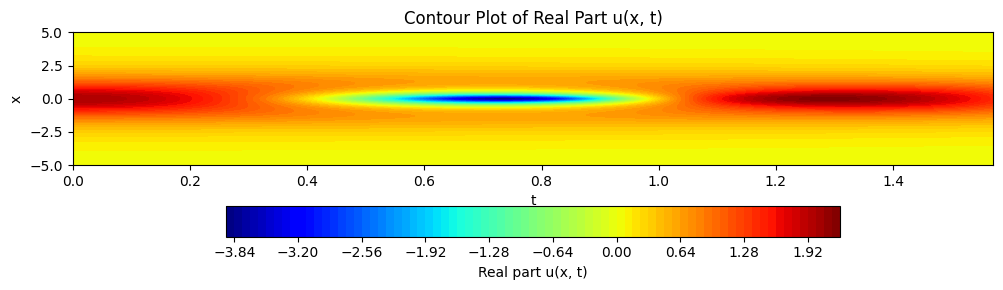

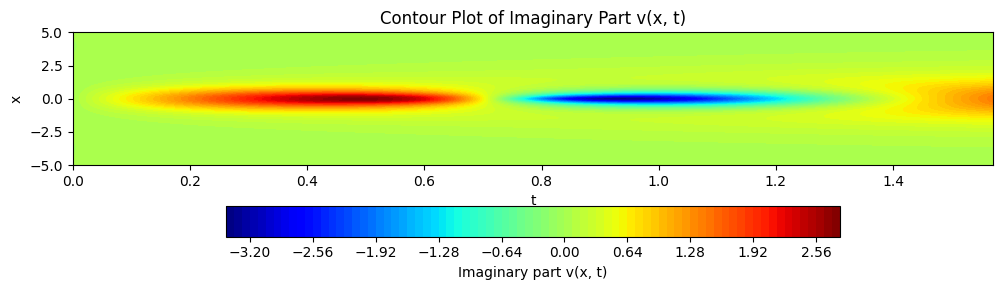

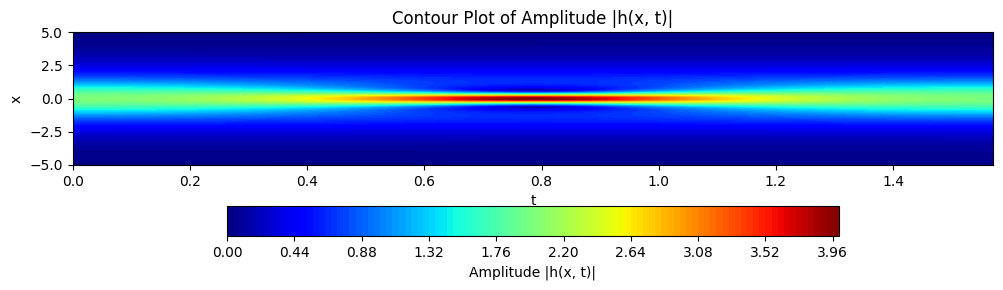

In [10]:
# Figure size for all contour/line plots
fig_width = 10
fig_height = 3

# =============================
# 1) Solution plots: u, v, |h|
# =============================

# Plot u(x, t): real part of the solution
plt.figure(figsize=(fig_width, fig_height))
contour = plt.contourf(T, X, u_pred, 100, cmap="jet")
cbar = plt.colorbar(contour, orientation="horizontal", pad=0.2)
cbar.set_label("Real part u(x, t)")
plt.title("Contour Plot of Real Part u(x, t)")
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi / 2)  # time from 0 to π/2
plt.ylim(-5, 5)         # spatial domain from -5 to 5
plt.tight_layout()
plt.show()

# Plot v(x, t): imaginary part of the solution
plt.figure(figsize=(fig_width, fig_height))
contour = plt.contourf(T, X, v_pred, 100, cmap="jet")
cbar = plt.colorbar(contour, orientation="horizontal", pad=0.2)
cbar.set_label("Imaginary part v(x, t)")
plt.title("Contour Plot of Imaginary Part v(x, t)")
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi / 2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Plot |h(x, t)|: amplitude (magnitude of complex solution)
plt.figure(figsize=(fig_width, fig_height))
contour = plt.contourf(T, X, h_pred, 100, cmap="jet")
cbar = plt.colorbar(contour, orientation="horizontal", pad=0.2)
cbar.set_label("Amplitude |h(x, t)|")
plt.title("Contour Plot of Amplitude |h(x, t)|")
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi / 2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()





Residuals (u): Mean = 1.0874e-03, Max = 1.3307e-02
Residuals (v): Mean = 1.0152e-03, Max = 2.1889e-02


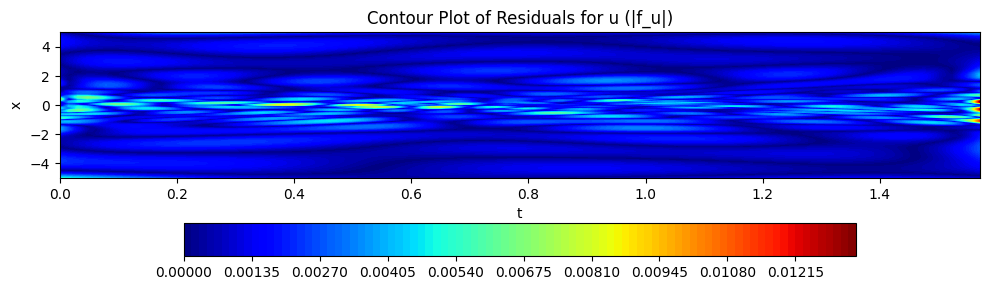

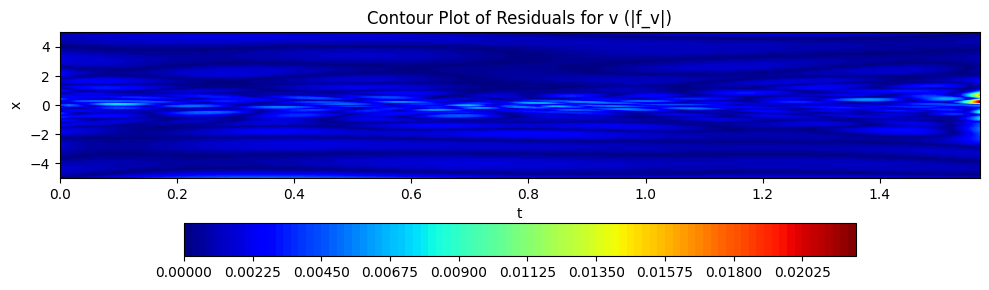

In [11]:
# =====================================
# 2) Physics-informed residuals (PDE f)
# =====================================

# Evaluate symbolic PDE residuals at test points
y_symbolic = model.predict(X_test, operator=pde)
f_u = y_symbolic[0].reshape(100, 200)  # residual for real part u
f_v = y_symbolic[1].reshape(100, 200)  # residual for imag part v

# Basic residual statistics (mean / max absolute error)
f_u_mean = np.mean(np.abs(f_u))
f_u_max = np.max(np.abs(f_u))
f_v_mean = np.mean(np.abs(f_v))
f_v_max = np.max(np.abs(f_v))

print(f"Residuals (u): Mean = {f_u_mean:.4e}, Max = {f_u_max:.4e}")
print(f"Residuals (v): Mean = {f_v_mean:.4e}, Max = {f_v_max:.4e}")

# Residual contour for u
plt.figure(figsize=(fig_width, fig_height))
plt.contourf(T, X, np.abs(f_u), 100, cmap="jet")
plt.colorbar(orientation="horizontal", pad=0.2)
plt.title("Contour Plot of Residuals for u (|f_u|)")
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi / 2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Residual contour for v
plt.figure(figsize=(fig_width, fig_height))
plt.contourf(T, X, np.abs(f_v), 100, cmap="jet")
plt.colorbar(orientation="horizontal", pad=0.2)
plt.title("Contour Plot of Residuals for v (|f_v|)")
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi / 2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()


In [12]:

# =====================================
# 3) Boundary condition verification
#    (periodic in x: x = -5 ↔ x = 5)
# =====================================

# Take solution at left and right boundaries for all times
u_left = u_pred[:, 0]    # u(x=-5, t)
u_right = u_pred[:, -1]  # u(x= 5, t)
v_left = v_pred[:, 0]    # v(x=-5, t)
v_right = v_pred[:, -1]  # v(x= 5, t)

# Mean periodicity error in u, v
bc_error_u = np.mean(np.abs(u_left - u_right))
bc_error_v = np.mean(np.abs(v_left - v_right))

print(f"Boundary Condition Error (u): {bc_error_u:.4e}")
print(f"Boundary Condition Error (v): {bc_error_v:.4e}")

# =====================================
# 4) Initial condition verification t=0
# =====================================

# Flatten grids for convenience
X_flat = X.flatten()
T_flat = T.flatten()

# Identify points at t = 0
t0_mask = np.isclose(T_flat, 0.0)

# Predicted solution at first time slice (t = 0)
u_t0 = u_pred[0, :]
v_t0 = v_pred[0, :]

# Exact initial condition for u(x, 0)
u_true_t0 = 2 / np.cosh(X_flat[t0_mask])

# Average IC error for u and v
init_error_u = np.mean(np.abs(u_t0 - u_true_t0))
init_error_v = np.mean(np.abs(v_t0))  # v should be 0 at t = 0

print(f"Initial Condition Error (u): {init_error_u:.4e}")
print(f"Initial Condition Error (v): {init_error_v:.4e}")



Boundary Condition Error (u): 1.1908e-04
Boundary Condition Error (v): 1.5660e-04
Initial Condition Error (u): 1.1191e-03
Initial Condition Error (v): 2.8245e-04


Max energy change: 1.8115e-03


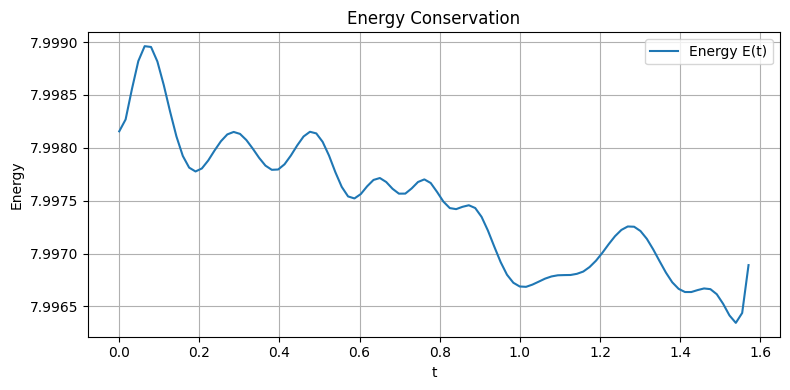

Max mass change: 1.8115e-03


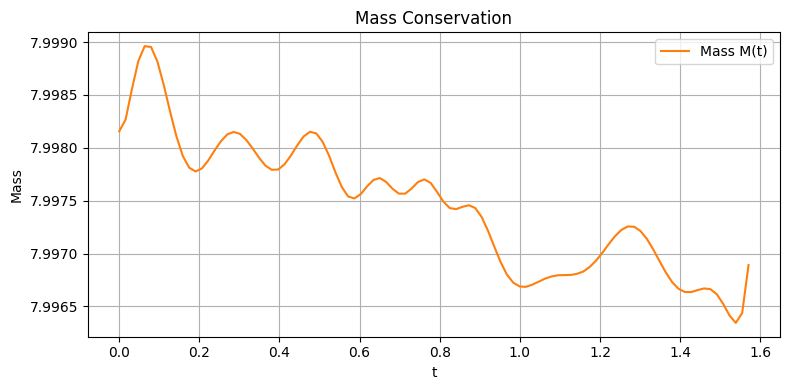

In [14]:
# ======================
# 5) Energy conservation
# ======================
'''
Energy conservation check for the Schrödinger PINN.

For the complex wave field
    h(x, t) = u(x, t) + i v(x, t),

the squared magnitude |h|^2 = u^2 + v^2 is conserved in time
(for the ideal Schrödinger equation with suitable boundary conditions).

We approximate the "energy-like" quantity

    E(t) = ∫ |h(x, t)|^2 dx

by a discrete sum over the spatial grid. If the PINN has learned a
physically consistent solution, E(t) should stay nearly constant over t,
and the maximum deviation from its initial value E(0) should be small.
'''

# Spatial step size (assumes uniform grid in x)
dx = (x_max - x_min) / (len(x) - 1)

# Total "energy" E(t) = ∫ (u^2 + v^2) dx  (discrete integral over x)
E_t = np.sum(u_pred**2 + v_pred**2, axis=1) * dx  # shape (Nt,)

# Deviation from initial energy over time
E_initial = E_t[0]
E_change = np.abs(E_t - E_initial)
max_E_change = np.max(E_change)

print(f"Max energy change: {max_E_change:.4e}")

# Plot E(t) vs time
plt.figure(figsize=(8, 4))
plt.plot(t, E_t, label="Energy E(t)")
plt.xlabel("t")
plt.ylabel("Energy")
plt.title("Energy Conservation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Example of another conservation rule that can be applied to other problems.
# convert energy to mass (just for example)
# ======================
# 6) Mass conservation
# ======================
'''
Mass conservation check.

For a general conservation law written as

    ∂ρ/∂t + ∂J/∂x = 0,

the total "mass"

    M(t) = ∫ ρ(x, t) dx

should remain constant in time (no sources/sinks and no flux through
the boundaries).

In this Schrödinger example, |h|^2 = u^2 + v^2 already plays the role of
a conserved density (probability mass). Therefore we can re-use

    ρ(x, t) = u(x, t)^2 + v(x, t)^2

to define M(t). For other PDEs you would replace ρ by the appropriate
physical density (e.g., fluid density, temperature, species
concentration, etc.).
'''

# "mass density" ρ(x, t) = u^2 + v^2
rho_xt = u_pred**2 + v_pred**2   # shape: (Nt, Nx)

# Total mass M(t) = ∫ ρ(x, t) dx  (discrete sum over x)
M_t = np.sum(rho_xt, axis=1) * dx  # shape: (Nt,)

# Deviation from initial mass
M_initial = M_t[0]
M_change = np.abs(M_t - M_initial)
max_M_change = np.max(M_change)

print(f"Max mass change: {max_M_change:.4e}")

# Plot M(t) vs time
plt.figure(figsize=(8, 4))
plt.plot(t, M_t, label="Mass M(t)", color="tab:orange")  # <-- 여기 수정
plt.xlabel("t")
plt.ylabel("Mass")
plt.title("Mass Conservation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
